In [1]:
import os
os.chdir('/home/david/Projects/optogenetic_whole_cell_activation/morph_impact_on_opt_stim')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neurostim.cell import Cell
from neurostim.stimulator import Stimulator
from neurostim.utils import convert_polar_to_cartesian_xz, interpolate
from neuron import h
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':8})
common_hue_order = ['apical tuft','apical shaft']
palette = ['tab:purple','tab:orange']

In [2]:
# format
# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl
# others
dpi=600

In [3]:
# cortical depth of neuron models
cortical_depth = {'L23': 400, 'L5': 1170} #um
# ChR2 expression distribution and level
chanrhod_distribution = 'uniform' 
chanrhod_soma_density = 13e9
# NEURON setup
h.load_file("stdrun.hoc")
h.cvode_active(1)
# load cell and create stimulation object
cell = Cell(
    hoc_file="simneurostim/model/hoc/L5.hoc",
    cortical_depth=cortical_depth,
    ChR_soma_density=chanrhod_soma_density,
    ChR_distribution=chanrhod_distribution
)
# function to label compartment type
def compartment_converter(seg):
    if 'ais' in str(seg):
        return 'soma/basal/axon'
    elif 'soma' in str(seg):
        return 'soma/basal/axon'
    elif 'dend11' in str(seg):
        if eval('h.'+str(seg)+'.z_chanrhod') > -300:
            return 'apical tuft'
        elif eval('h.'+str(seg)+'.z_chanrhod') > -850:
            return 'apical shaft'
        elif eval('h.'+str(seg)+'.z_chanrhod') > -1100 and eval('h.'+str(seg)+'.x_chanrhod')**2+eval('h.'+str(seg)+'.y_chanrhod')**2 < 170:
            return 'apical shaft'
        else:
            return 'soma/basal/axon'
    elif 'dend' in str(seg):
        return 'soma/basal/axon'
    elif 'myelin' in str(seg):
        return 'soma/basal/axon'
    elif 'nakeaxon' in str(seg):
        return 'soma/basal/axon'
    elif 'node' in str(seg):
        return 'soma/basal/axon'
    elif 'hill' in str(seg):
        return 'soma/basal/axon'
    else:
        return 'None'

	1 
	1 
	1 
	1 


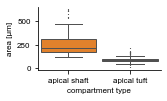

In [4]:
# area boxplot
segarea = []
for sec in h.allsec():
    for seg in sec:
        segarea.append(
            dict(
                name = str(seg),
                area = seg.area(),
            )
        )
segarea = pd.DataFrame(segarea)
segarea['seglabel'] = [compartment_converter(seg) for seg in segarea.name]
# filter out soma/basal/axon
segarea = segarea.loc[segarea.seglabel!='soma/basal/axon']
fig, ax = plt.subplots(figsize=(pw/3,pl/8))
ax = sns.boxplot(
    data=segarea, 
    x='seglabel', 
    y='area', 
    hue='seglabel', 
    hue_order=common_hue_order,
    palette=palette,
    dodge=False, ax=ax,
    fliersize=0.3, linewidth=1, width=0.9)
ax.get_legend().remove()
ax.set_ylabel('area [µm]')
ax.set_xlabel('compartment type')
#ax.set_xticklabels(['ap. shaft','ap. dend.'])
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/appendix_area_vs_comptype.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

In [5]:
# light intensity boxplot
def light_source_displacement_and_light_calculation(
    radius, angle):
    """
    Calculates the light intensity at segments normalized to stimulator surface output intensity.
    Returns segments, normed_light_intensity
    """
    # light source model and params
    light_model = 'fiber_Foutz2012'
    fiber_diameter = 200 #um
    fiber_NA = 0.22
    # stimulation power and duration
    light_power = 1 #W
    light_duration = 200 # ms
    stim_intensity_at_stim_surface_mWPERmm2 = light_power/(0.5**2*(fiber_diameter*1e-3)**2*np.pi)*1e3# mW/mm2
    #print("Stimulation intensity at simulator surface: "+str(stim_intensity_at_stim_surface_mWPERmm2)+' mW/mm2')
    stim_intensity_at_stim_surface_WPERcm2 = stim_intensity_at_stim_surface_mWPERmm2 * 1e-3 * 1e2 # mW->W // 1/mm2 -> 1/cm2
    
    # light source initialization
    stimulator = Stimulator(fiber_diameter, fiber_NA)
    light_x, light_y = convert_polar_to_cartesian_xz(radius, angle)
    light_z = 0  # cortical surface
    light_pos = (light_x, light_y, light_z)
    segs_Txs = [[],[]]
    for sec in h.allsec():
        for seg in sec:
            if sec.name() == 'Light_source: fiber_Foutz2012':
                pass
            else:
                segs_Txs[0].append(seg)
                segs_Txs[1].append(
                    # calculate Tx at position
                    stimulator.calculate_Tx_at_pos(
                        pos_xyz_um = [seg.x_chanrhod, seg.y_chanrhod, seg.z_chanrhod],
                        stim_xyz_um = light_pos,
                    )
                )
    #return np.array(segs_Txs[0]), np.array(segs_Txs[1])/stim_intensity_at_stim_surface_WPERcm2
    return segs_Txs[0], np.array(segs_Txs[1])/stim_intensity_at_stim_surface_WPERcm2

In [6]:
seg_lightintensity = []
segs, normed_intensity = light_source_displacement_and_light_calculation(radius=0, angle=0)
for seg, normed_intensity in zip(segs, normed_intensity):
    seg_lightintensity.append(dict(
        name=seg, normed_intensity=normed_intensity, radius=0, angle=0
    ))
seg_lightintensity = pd.DataFrame(seg_lightintensity)
seg_lightintensity['seglabel'] = [compartment_converter(seg) for seg in seg_lightintensity['name']]
# filter out soma basal axon
seg_lightintensity = seg_lightintensity.loc[seg_lightintensity.seglabel!='soma/basal/axon']

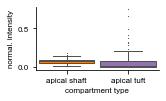

In [9]:
fig, ax = plt.subplots(figsize=(pw/3,pl/8))
ax = sns.boxplot(
    data=seg_lightintensity, 
    x='seglabel', 
    y='normed_intensity', 
    hue='seglabel', 
    hue_order=common_hue_order,
    palette=palette,
    dodge=False,ax=ax,
    fliersize=0.3, linewidth=1, width=0.9)
ax.get_legend().remove()
ax.set_ylabel('normal. intensity')
ax.set_xlabel('compartment type')
#ax.set_xticklabels(['other', 'ap. shaft','ap. dend.'])
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/appendix_intensity_vs_comptype_central_stimposition.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

In [10]:
# unit of Tx: intensity at position = Tx * light_power => [W/cm2] // Tx -> [1/cm2] 

In [11]:
data = pd.read_hdf('data/2023-09-22_conductances/all_data.hdf')
# reduce fixed params
neuron='L5'
light_model='foutz_et_al2012'
ChRdistrib = 'uniform'
ChRexpression=13e9
fiber_d=200
fiber_NA=0.22
stim_duration=200
radius=0
angle=0
data = data.loc[neuron,light_model,ChRdistrib,ChRexpression,fiber_d,fiber_NA,stim_duration,:,radius,angle]
data['seglabel'] = [compartment_converter(seg) for seg in data.reset_index().segname]

In [12]:
# filter out soma/basal/axon
data = data.loc[data.seglabel!='soma/basal/axon']

In [13]:
0.0003/(0.1**2*np.pi)

0.00954929658551372

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


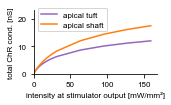

In [14]:
data['stim_intensity [mW/mm2]'] = (data.reset_index()['light_power'] / (0.1**2*np.pi) *1e3).values
data_total_per_seglabel = pd.DataFrame(
    data.groupby(['stim_intensity [mW/mm2]','seglabel']).mean_conductance_pS.sum())
fig, ax = plt.subplots(figsize=(pw/3,pl/8))
ax = sns.lineplot(
    data=data_total_per_seglabel.reset_index(), 
    x='stim_intensity [mW/mm2]', 
    y="mean_conductance_pS", 
    hue="seglabel",
    hue_order=common_hue_order,
    palette=palette,
    markers=True,
    ax=ax,
    legend='brief'
)
plt.legend(loc='upper left', bbox_to_anchor=(0.0, 1.1))
#ax.get_legend().remove()
ax.set_ylim(0,23000)
ax.set_yticklabels(['0','10','20'])
ax.set_xlim(0,None)
ax.set_xlabel('intensity at stimulator output [mW/mm²]')
ax.set_ylabel('total ChR cond. [nS]')
# inset = fig.add_axes([0.26,0.68,0.19,0.19])

# sns.lineplot(
#     data=data_max_positions_mean_over_seglabel, 
#     x='stim_intensity [mW/mm2]', 
#     y="mean_conductance_pS", 
#     hue="seglabel",
#     hue_order=common_hue_order,
#     palette=palette,
#     markers=True,
#     ax=inset
# )
# inset.get_legend().remove()
# inset.set_ylim(0,100)
# inset.set_xlim(0,10)
# inset.set_xlabel('')
# inset.set_ylabel('')

fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/appendix_condVSstim_power_central_stimposition.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
           bbox_inches='tight')
plt.show()